# Attempting the Cloud Labels
-----------------------------------------
### Raw notebook as I played with the data. I just trained simple classifiers to the first moments of the pixel values found in the images. Just to see how they did.


### We first import useful libraries and the training labels

In [4]:
import matplotlib.pyplot as plt #importing some useful libraries
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
train_labels_tmp=pd.read_csv("train.csv")

In [5]:
np.where(train_labels_tmp.values[:][1]=='') #all images have labels. Lets see what they are.

(array([], dtype=int64),)

### Finding the unique labels and splitting them into two sets: Cloud Labels and Forest Labels. We focus on the cloud labelling first.

In [6]:
labels=[]
for i in range(len(train_labels_tmp.values)):
    labels=np.unique(np.append(labels,train_labels_tmp.values[i][1].split())) 
cloud_labels=np.array([labels[5],labels[6],labels[10],labels[11]])
forest_labels=np.array(list(set(labels)-set(cloud_labels)))
print(cloud_labels)
print(forest_labels)

['clear' 'cloudy' 'haze' 'partly_cloudy']
['road' 'conventional_mine' 'blow_down' 'artisinal_mine' 'blooming'
 'cultivation' 'selective_logging' 'water' 'agriculture' 'slash_burn'
 'habitation' 'primary' 'bare_ground']


### Let us turn these labels into numbers and then into vectors which can be used as onevsall inputs.

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

def cloud2num(x):
    l=np.array(x.split())
    for i in range(len(cloud_labels)):
        if(len(l[l==cloud_labels[i]])>0):
            return [i]
def forest2num(x):
    l=np.array(x.split())
    labels=[]
    for i in range(len(forest_labels)):
        if(len(l[l==forest_labels[i]])>0):
            labels.append(i)
    if(len(labels)>0): return labels
    return [len(forest_labels)] #If no labels are present, (i.e. only "cloudy" photo)

train_labels_cloud=[cloud2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_cloud=np.array(train_labels_cloud).ravel()
#train_labels_cloud=MultiLabelBinarizer().fit_transform(train_labels_cloud) #turns the integers into vectors
train_labels_forest=[forest2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_forest=np.array(train_labels_forest).ravel()
#train_labels_forest=MultiLabelBinarizer().fit_transform(train_labels_forest) #turns the integers into vectors


### We should now have two vectorized training labels: forest and cloud. The image *i* will then have labels *train_labels_cloud[i]* and *train_labels_forest[i]*. 

------
## Cloud Data/Labels
-------
### Lets look at the distribution,

In [8]:
np.mean(train_labels_cloud,axis=0)

0.72810593147063907

### Mostly clear label. Haze and cloudy are each about 6% of the data.

### Lets try something very easy, namely simply looking at the moments of our images.

In [48]:
from scipy.stats import moment
from skimage import measure as ms
def preprocess(img):
    img=np.reshape((plt.imread(img)-128)/128,((256*256,4)))
    mean=np.mean(img,axis=0)
    variance=np.var(img,axis=0)
    #kurtosis=moment(img,moment=3,axis=0)
    #skew=moment(img,moment=4,axis=0)   
    return np.concatenate((mean,variance),axis=0)
def extractfeatures(numarray):
    features=[]
    for i in numarray:
        features.append(preprocess('train-jpg/train_'+str(i)+'.jpg'))
    return np.array(features)

trainNum=2000
testNum=2000
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum

%time features_train=extractfeatures(numarray_train)
features_test=extractfeatures(numarray_test)

CPU times: user 15.4 s, sys: 72 ms, total: 15.5 s
Wall time: 15.5 s


In [50]:

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC

def testmodels(features_object_train,features_object_test,trainNum=trainNum,testNum=testNum):
    features_trainwE=features_object_train
    features_testwE=features_object_test

    LR=LogisticRegression()
    LR.fit(features_trainwE,train_labels_cloud[:trainNum])
    trainscore=LR.score(features_trainwE,train_labels_cloud[:trainNum])
    testscore=LR.score(features_testwE,train_labels_cloud[trainNum:trainNum+testNum])


    lda=LDA()
    lda.fit(features_trainwE,train_labels_cloud[:trainNum])
    trainscorelda=lda.score(features_trainwE,train_labels_cloud[:trainNum])
    testscorelda=lda.score(features_testwE,train_labels_cloud[trainNum:trainNum+testNum])

    rfc=RFC()
    rfc.fit(features_trainwE,train_labels_cloud[:trainNum])
    trainscorerfc=rfc.score(features_trainwE,train_labels_cloud[:trainNum])
    testscorerfc=rfc.score(features_testwE,train_labels_cloud[trainNum:trainNum+testNum])

    gbc=GBC()
    gbc.fit(features_trainwE,train_labels_cloud[:trainNum])
    trainscoregbc=gbc.score(features_trainwE,train_labels_cloud[:trainNum])
    testscoregbc=gbc.score(features_testwE,train_labels_cloud[trainNum:trainNum+testNum])

    testlabels=train_labels_cloud[trainNum:testNum+trainNum]
    print('The LogReg training score is: ', trainscore)
    print('The LogReg test score is:', testscore, ' and the f1 score is ', f1score(LR,features_testwE,testlabels))
    print('The LDA training score is: ', trainscorelda)
    print('The LDA test score is:', testscorelda, ' and the f1 score is ', f1score(lda,features_testwE,testlabels))
    print('The RFC training score is: ', trainscorerfc)
    print('The RFC test score is:', testscorerfc, ' and the f1 score is ', f1score(rfc,features_testwE,testlabels))
    print('The GBC training score is: ', trainscoregbc)
    print('The GBC test score is:', testscoregbc, ' and the f1 score is ', f1score(gbc,features_testwE,testlabels))
    return

testmodels(features_train,features_test)

/home/phrenk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The LogReg training score is:  0.741
The LogReg test score is: 0.73  and the f1 score is  0.791742220452
The LDA training score is:  0.7445
The LDA test score is: 0.7455  and the f1 score is  0.78860674539
The RFC training score is:  0.986
The RFC test score is: 0.806  and the f1 score is  0.813727545163
The GBC training score is:  0.941
The GBC test score is: 0.8235  and the f1 score is  0.829130269336


### Simple linear analysis can't do very well with the given features. Either go to more complex models such as RFC, or get better features. I am a bit surprised by the terrible performance here. Let us see what we are getting wrong with LogReg.

### Below shows the following plot: we choose the three features that have largest coefficients in the model that classifies if the sky is clear or not. These are the features that should dominate the decision. We can see that there is a lot of overlap (looking at the histograms, most of the purple points lie on top of the blue ones). 

In [12]:
maxcoeff=[np.argsort(LR.coef_[i])[:3] for i in range(len(LR.coef_))]
maxcoeff

[array([0, 6, 5]), array([1, 2, 0]), array([1, 3, 4]), array([3, 2, 7])]

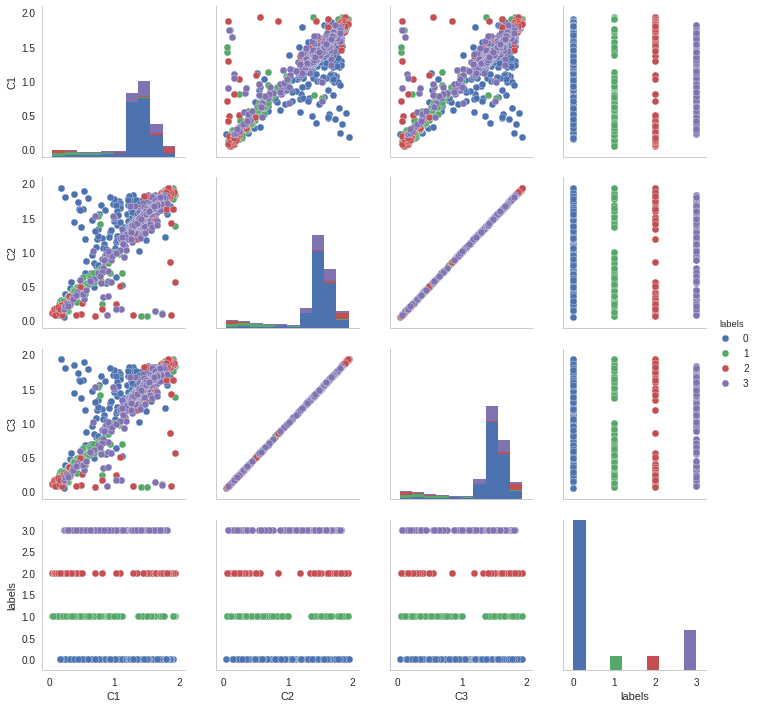

In [13]:
sns.set_style("whitegrid", {'axes.grid' : False})

df=pd.DataFrame({"C1": features_train[:,maxcoeff[0][0]],"C2": features_train[:,maxcoeff[1][0]],"C3": features_train[:,maxcoeff[2][0]],"labels":train_labels_cloud[:trainNum]})
sns.pairplot(df,hue="labels")

### Let us take a look at the confusion matrix.

/home/phrenk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/phrenk/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


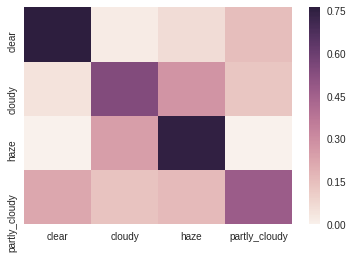

In [14]:
from sklearn.metrics import confusion_matrix as CM

Confmatrix=CM(LR.predict(features_test),train_labels_cloud[trainNum:trainNum+testNum])
ConfmatrixRescaled=[Confmatrix[i]/np.sum(Confmatrix,axis=1)[i] for i in range(4)]
g=sns.heatmap(ConfmatrixRescaled,xticklabels=cloud_labels,yticklabels=cloud_labels)


### The classifier is able to predict *clear* and *haze* the most accurately, but it is all over the place. The worse seems to be differentiating between *cloudy* and *haze* when a cloudy image is given. Lets look at misclassified pictures I guess

There are 540 misclassified test cases.
Predicted: partly_cloudy True Label: cloudy


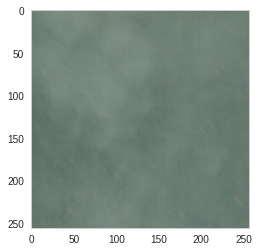

In [15]:
BadClass=np.where(LR.predict(features_test)!=train_labels_cloud[trainNum:trainNum+testNum])[0]
BadPred=LR.predict(features_test)[BadClass]
print("There are "+str(len(BadClass))+" misclassified test cases.")
def testimage(prednum):
    imgnum=BadClass[prednum]+trainNum
    print('Predicted: '+cloud_labels[BadPred[prednum]]+' True Label: '+cloud_labels[train_labels_cloud[imgnum]])
    plt.imshow(plt.imread('train-jpg/train_'+str(imgnum)+'.jpg'))
testimage(20)

Predicted: cloudy True Label: partly_cloudy


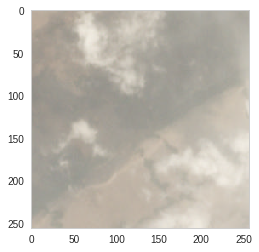

In [16]:
testimage(150)

Predicted: clear True Label: partly_cloudy


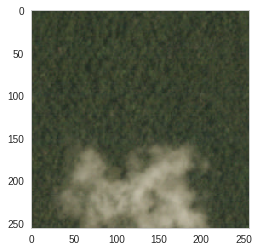

In [17]:
testimage(35)

Predicted: partly_cloudy True Label: clear


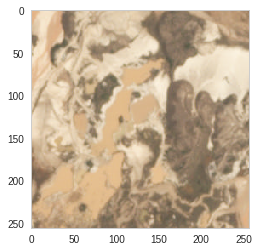

In [18]:
testimage(50)

### Test if for yourself... but I tend to agree with the classifier on these random choices I've just tried. There seems to be a lot of mislabeled images? Here's one (argument = 300) that I can agree was wrong:

Predicted: cloudy True Label: haze


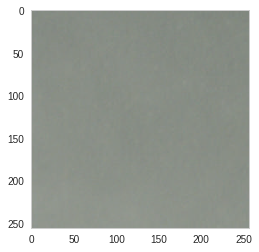

In [19]:
testimage(300)

Predicted: clear True Label: haze


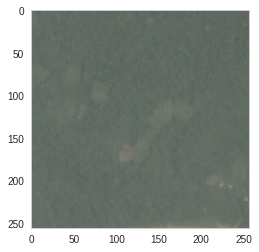

In [20]:
testimage(350)

Predicted: clear True Label: haze


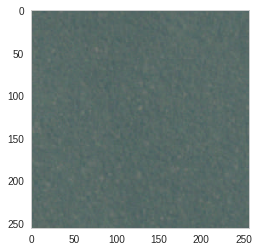

In [21]:
testimage(370)

### There is a level of subjectivity that comes into play when determining if something is partly_cloudy.

## Developping edge features.

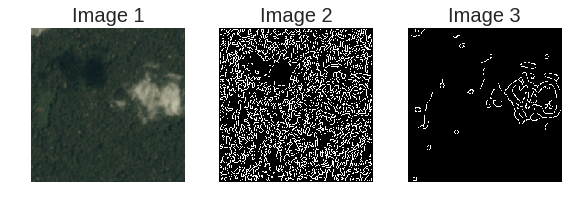

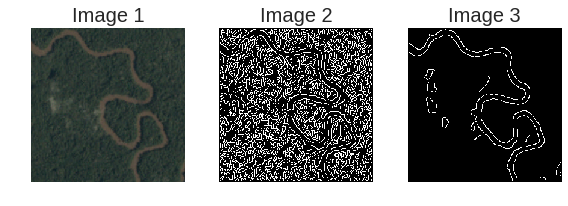

In [23]:
sigtest=2.5
def plotpics(p1,p2,p3,sigtest=sigtest):
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

    ax1.imshow(p1, cmap=plt.cm.gray)
    ax1.axis('off')
    ax1.set_title('Image 1', fontsize=20)

    ax2.imshow(p2, cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title('Image 2', fontsize=20)

    ax3.imshow(p3, cmap=plt.cm.gray)
    ax3.axis('off')
    ax3.set_title('Image 3', fontsize=20)

    fig.tight_layout()
    return plt.show()


from skimage import feature
def edgefeatures(img):
    edges=feature.canny(img)
    return edges

img='train-jpg/train_99.jpg'
imgt=plt.imread(img)
img=(imgt-128)/128
sigtest=2.5
edges1=feature.canny(img[:,:,0])
edges2=feature.canny(img[:,:,0],sigma=sigtest)

plotpics(imgt,edges1,edges2,sigtest=sigtest)

img='train-jpg/train_1700.jpg'
imgt=plt.imread(img)
img=(imgt-128)/128
sigtest=2.5
edges1=feature.canny(img[:,:,0])
edges2=feature.canny(img[:,:,0],sigma=sigtest)

plotpics(imgt,edges1,edges2,sigtest=sigtest)

The canny algorithm does a good job detecting the shapes involved in the problem. 
It seems that there is a sweet spot with $\sigma=2.5$. I have not tested this super carefully.
Let's try to apply a convolution filter to the edges and then cross correlate the 
convoluted image with the the RGB pixel found. We will create the following features:
- density of edges in the image
- statistics of the pixel colors correlated with the edges


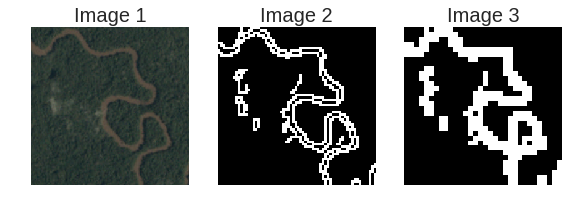

In [24]:
#from scipy.ndimage.filters import maximum_filter

#pool_edges1=edges1*(maximum_filter(edges1,footprint=np.ones((64,64))))
#pool_edges2=edges2*(maximum_filter(edges2,footprint=np.ones((8,8))))
#plotpics(img,pool_edges1,pool_edges2,sigtest=sigtest)

def maxpooling(img,n):
    N=int(np.shape(img)[0]/n)
    pool=np.zeros((N,N))
    for i in range(N):
        #pool[i]=np.array([np.amax(img[i*n:(i+1)*n,j*n:(j+1)*n]) for j in range(N)])
        for j in range(N):
            pool[i,j]=np.amax(img[i*n:(i+1)*n,j*n:(j+1)*n])
    return pool

pool_edges1=maxpooling(edges2,4)
pool_edges2=maxpooling(edges2,8)
plotpics(imgt,pool_edges1,pool_edges2,sigtest=sigtest)


The max pooling with 8x8 matrix looks really promising. Below I try to "fill" in the holes. It does not improve the picture very much. I'm going to go ahead and not bother with it.

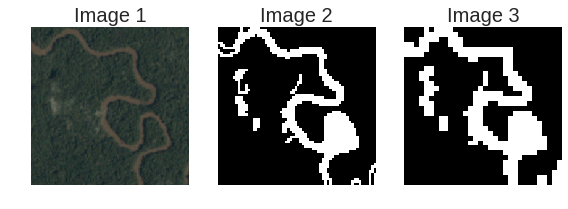

In [26]:
from scipy import ndimage as ndi
fill_edges1 = ndi.binary_fill_holes(pool_edges1)
fill_edges2 = ndi.binary_fill_holes(pool_edges2)

plotpics(imgt,fill_edges1,fill_edges2,sigtest=sigtest)

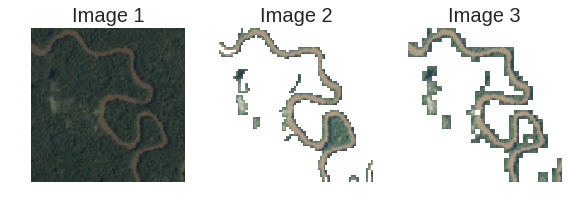

In [27]:
def filter_img_edges(img,edge_filter):
    N=np.shape(edge_filter)[0]
    n=int(np.shape(img)[0]/N)
    newimg=np.zeros((np.shape(img)))
    for i in range(N):
        for j in range(N):
            if(edge_filter[i,j]):
                newimg[i*n:n*(i+1),j*n:n*(j+1)]=img[i*n:n*(i+1),j*n:n*(j+1)]
    return newimg

def filter_img_edges_features(img,edge_filter):
    N=np.shape(edge_filter)[0]
    n=int(np.shape(img)[0]/N)
    window=np.zeros((np.shape(img[0:n,0:n])))
    edgefeatures=[[0,0]]
    for i in range(N):
        for j in range(N):
            if(edge_filter[i,j]):
                window=img[i*n:n*(i+1),j*n:n*(j+1)]
                mean=np.mean(window)
                variance=np.var(window)
                edgefeatures.append([mean,variance])
    return np.mean(edgefeatures,axis=0)

filledges1=filter_img_edges(img,fill_edges1)
filledges2=filter_img_edges(img,pool_edges2)

plotpics(imgt,filledges1,filledges2,sigtest=sigtest)

Applying the above functions to our data set. It takes about a minute on 1/20th of all the training images on my very average laptop (i5, 2.3Ghz cpu) .

In [28]:
def extractfeaturesedge(numarray,rgbnum=0):
    features=[]
    for i in numarray:
        img='train-jpg/train_'+str(i)+'.jpg'
        img=(plt.imread(img)-128)/128
        sigtest=2.5
        edges=maxpooling(feature.canny(img[:,:,rgbnum],sigma=sigtest),8)
        features.append(filter_img_edges_features(img,edges))
    return np.array(features)


CPU times: user 1min 7s, sys: 3.25 s, total: 1min 10s
Wall time: 1min 10s


In [ ]:
%time features_edge_train=extractfeaturesedge(numarray_train)
features_edge_test=extractfeaturesedge(numarray_test)

features_train=np.concatenate((features_train,features_edge_train),axis=1)
features_test=np.concatenate((features_test,features_edge_test),axis=1)

In [31]:
testmodels(features_train,features_test)

/home/phrenk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The LogReg training score is:  0.747
The LogReg test score is: 0.743  and the f1 score is  0.796272652706
The LDA training score is:  0.7535
The LDA test score is: 0.752  and the f1 score is  0.786666576789
The RFC training score is:  0.991
The RFC test score is: 0.818  and the f1 score is  0.823590057054
The GBC training score is:  0.947
The GBC test score is: 0.8305  and the f1 score is  0.835608362634


Lets try to pick out the individual objects. We try it with the contour and labelling connected components method. The labelling one works beautifully in this simple case of the river.

In [32]:
from skimage.measure import find_contours
from skimage.measure import label

img_contours=find_contours(pool_edges2,level=0.5,fully_connected='low')
img_label=label(pool_edges2,neighbors=4)

Object filtering through contours


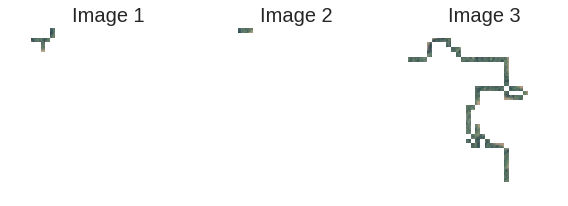

Object Filtering through labels


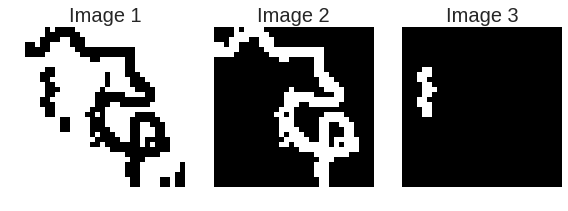

In [33]:

def get_contours(img_contours):
    contours=[]
    for j in range(len(img_contours)):
        cont_tmp=np.zeros((np.shape(pool_edges2)),dtype=bool)
        for ind in np.round(img_contours[j]).astype(int):
            cont_tmp[ind[0],ind[1]]=True
        contours.append(cont_tmp)
    return contours
def get_objects(img_label):
    objects=[]
    objsID=np.unique(img_label)
    for j in range(len(objsID)):
        cont_tmp=np.zeros((np.shape(pool_edges2)),dtype=bool)
        cont_tmp[np.where(img_label==objsID[j])]=True
        objects.append(cont_tmp)
    return objects

conts=get_contours(img_contours)
cont_filter=[]
for i in range(len(conts)):
    cont_filter.append(filter_img_edges(img,conts[i]))
print('Object filtering through contours')
for i in range(1):    
    plotpics(cont_filter[i],cont_filter[i+1],cont_filter[i+3])
print('Object Filtering through labels')
objects=get_objects(img_label)
plotpics(objects[0],objects[1],objects[2])

Here we put all this code together to test it on other images.

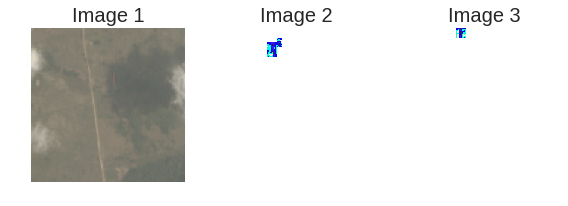

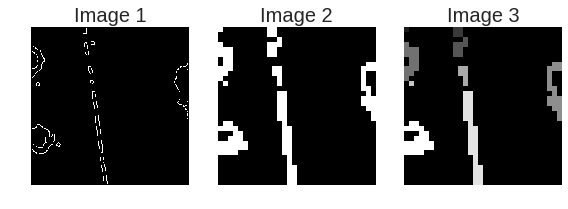

In [77]:
def get_img_objects(i,fill=False,objects_only=False,rgbnum=0):
    img='train-jpg/train_'+str(i)+'.jpg'
    img=(plt.imread(img)-128)/128
    sigtest=2.5
    edges=feature.canny(img[:,:,rgbnum],sigma=sigtest) #only one of the 3 images provided being analyzed - must change
    mpool=maxpooling(edges,8)
    if(fill):
        mpool= ndi.binary_fill_holes(mpool)
    labelled=label(mpool,neighbors=4)
    objects=get_objects(labelled)
    obj_imgs=[]
    for ob in objects:#I don't want the background so I start with 1
        obj_imgs.append(filter_img_edges(img,ob))
    if(objects_only):
        return obj_imgs,objects
    return obj_imgs,objects,edges,mpool,labelled
#the river image was number 1700
#show 80 vs i=0 and i=2 for the edge detection
#show 1000. Cloud gets picked up but not the inside. - filling the holes can maybe fix it
imgnum=80
obj_imgs,objects,edges,mpool,labelled=get_img_objects(imgnum,fill=False,rgbnum=2)
plotpics(plt.imread('train-jpg/train_'+str(imgnum)+'.jpg'),obj_imgs[3],obj_imgs[2])
plotpics(edges,mpool,labelled)


So, at first sight, this seem to work nicely.

What can we do with this? The following might work.

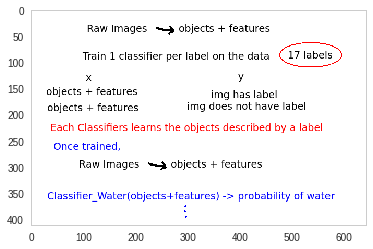

In [35]:
plt.imshow(plt.imread('idea.png'))

### Building more useful features for the objects

In [36]:
from skimage.measure import perimeter as skper
imsizepix=32*32
def objects_features(obj_imgs,objects):
    obj_feature=np.zeros((len(objects),4))
    for i in range(len(objects)):
        area=np.max(np.sum(objects[i])-1,0)
        peri=skper(objects[i])+0.0001
        #print(peri,area,i)
        obj_feature[i][0]=(16*area)/(peri*peri) #unitless: interpolates between 1 for a square, 0 for a line
        if(obj_feature[i][0]>1.5): obj_feature[i][0]=1.5
        obj_feature[i][1]=np.mean(obj_imgs[i]) #mean pixel
        obj_feature[i][2]=np.var(obj_imgs[i])   #var pixel
        obj_feature[i][3]=area/imsizepix #percent of area covered
    return len(objects),obj_feature

obj_imgs,objects=get_img_objects(1,fill=False,objects_only=True) #get the objects
n,obj=objects_features(obj_imgs,objects)

We need to find a nice way of feeding the objects to the classifiers. The number of objects can change. This is a problem, the classifier expects a constant number of features.
- Number of objects
- 3 objects (randomly?) chosen objects of a given size -- Careful! Rare cases must appear.
- the 3 objects with largest of each features
- the object which appears the most? (think of 10 tiny houses)
- object of largest size

In [70]:
def extract_new_data(numarray,fill=False,returnall=False):
    data=[]
    labels=[]
    for i in numarray:
        obj_imgs,objects=get_img_objects(i,fill=fill,objects_only=True,rgbnum=0)
        for j in range(1,3):
            obj_imgsTMP,objectsTMP=get_img_objects(i,fill=fill,objects_only=True,rgbnum=j) #get the objects
            obj_imgs=np.concatenate((obj_imgs,obj_imgsTMP),axis=0)
            objects=np.concatenate((objects,objectsTMP),axis=0)
        n,objs=objects_features(obj_imgs,objects)
        ind_largest_feats=[np.argsort([o[j] for o in objs])[0] for j in range(len(objs[0]))]
        largest_feats=np.array([objs[k] for k in ind_largest_feats])
        #random_choice=np.array([objs[k] for k in np.random.choice(np.arange(n),3)])
        most_line_like=np.argmin([o[0] for o in objs])
        largest_feats[0]=objs[most_line_like]
        
        #data.append(np.concatenate(([n],largest_feats.flatten(),random_choice.flatten()),axis=0))
        if(returnall):
            data.append([n,objs])
        else:
            data.append(np.concatenate(([n],largest_feats.flatten()),axis=0))
    if(returnall):
        return n,objs
    return data



In [61]:
trainNum=2000
testNum=2000
%time features_object_train=extract_new_data(numarray_train)
features_object_test=extract_new_data(numarray_test)

CPU times: user 4min 7s, sys: 14.9 s, total: 4min 22s
Wall time: 4min 23s


In [62]:
testmodels(features_object_train,features_object_test)

The LogReg training score is:  0.7255
The LogReg test score is: 0.723  and the f1 score is  0.770666194253
The LDA training score is:  0.7345
The LDA test score is: 0.732  and the f1 score is  0.76094485472
The RFC training score is:  0.987
The RFC test score is: 0.7635  and the f1 score is  0.77596166059
The GBC training score is:  0.9385
The GBC test score is: 0.778  and the f1 score is  0.789211105683


Getting the features takes a about 90 sec for 1/20th of the data. However it still doesn't do very differently than simply taking the mean and variance of the entire image!! Maybe with fill?

In [56]:
trainNum=2000
testNum=2000
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum

%time features_object_train=extract_new_data(numarray_train,fill=True)
features_object_test=extract_new_data(numarray_test,fill=True)

testmodels(features_object_train,features_object_test,trainNum=trainNum,testNum=testNum)

CPU times: user 1min 15s, sys: 3.29 s, total: 1min 19s
Wall time: 1min 19s
The LogReg training score is:  0.7235
The LogReg test score is: 0.706  and the f1 score is  0.801951177476
The LDA training score is:  0.7105
The LDA test score is: 0.7  and the f1 score is  0.761330654226
The RFC training score is:  0.9805
The RFC test score is: 0.742  and the f1 score is  0.769759704151
The GBC training score is:  0.8905
The GBC test score is: 0.7515  and the f1 score is  0.779533517553


No cigar either. Can RFC do better with more data?

In [43]:
trainNum=10000
testNum=2000
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum
trainlabels=train_labels_cloud[:trainNum]
testlabels=train_labels_cloud[trainNum:testNum+trainNum]

In [44]:
%time features_object_train_10k=extract_new_data(numarray_train)
features_object_test_10k=extract_new_data(numarray_test)

CPU times: user 6min 41s, sys: 17.3 s, total: 6min 58s
Wall time: 7min 1s


In [52]:
trainNum=10000
testNum=2000
testmodels(features_object_train_10k,features_object_test_10k,trainNum=trainNum,testNum=testNum)

/home/phrenk/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


The LogReg training score is:  0.7115
The LogReg test score is: 0.7335  and the f1 score is  0.808993636008
The LDA training score is:  0.7125
The LDA test score is: 0.7185  and the f1 score is  0.766215406903
The RFC training score is:  0.9842
The RFC test score is: 0.773  and the f1 score is  0.78405484889
The GBC training score is:  0.819
The GBC test score is: 0.788  and the f1 score is  0.803013191288


In [71]:
trainNum=500
testNum=500
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum

%time all_objs_train=extract_new_data(numarray_train,returnall=True)
all_objs_test=extract_new_data(numarray_test,returnall=True)


CPU times: user 1min 5s, sys: 1.78 s, total: 1min 6s
Wall time: 1min 6s


In [69]:
all_objs_train

(16, array([[  2.97943004e-01,   1.29973772e+00,   1.61720805e-01,
           9.37500000e-01],
        [  1.50000000e+00,   5.36206365e-03,   7.53565302e-03,
           2.92968750e-03],
        [  1.50000000e+00,   5.45105338e-03,   7.80220619e-03,
           2.92968750e-03],
        [  1.50000000e+00,   4.15208936e-03,   6.05598521e-03,
           1.95312500e-03],
        [  1.50000000e+00,   5.52731752e-03,   8.04090440e-03,
           2.92968750e-03],
        [  1.50000000e+00,   5.47066331e-03,   7.85986999e-03,
           2.92968750e-03],
        [  1.50000000e+00,   5.39964437e-03,   7.64702709e-03,
           2.92968750e-03],
        [  1.49448210e+00,   2.05706656e-02,   2.93492777e-02,
           1.36718750e-02],
        [  1.50000000e+00,   2.67991424e-03,   3.77143379e-03,
           9.76562500e-04],
        [  0.00000000e+00,   1.35388970e-03,   1.92767807e-03,
           0.00000000e+00],
        [  1.50000000e+00,   5.51593304e-03,   8.00529667e-03,
           2.92968750e-